In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

import Library 

# Clustering libraries
from sklearn.cluster       import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.metrics       import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA

## <hr><center>Load the datasets cleaned by the Task 1 Notebook</center><hr>

In [ ]:
players_df = pd.read_csv('../data_cleaned/players.csv')
print(f'(players_df) Loading {players_df.shape[0]} rows from "../data_cleaned/players_df.csv"')

matches_df = pd.read_csv('../data_cleaned/matches_side.csv')
print(f'(matches_side_df) Loading {matches_df.shape[0]} rows from "../data_cleaned/matches_side_df.csv"')

players_statistics    = Library.deserialize_statistics('../data_cleaned/players_df.stat')
match_side_statistics = Library.deserialize_statistics('../data_cleaned/match_side_df.stat')

(players_df) Loading 1918 rows from "../data_cleaned/players_df.csv"
(matches_side_df) Loading 370946 rows from "../data_cleaned/matches_side_df.csv"


## <hr><center>K-Means Clustering</center><hr>

<AxesSubplot:>

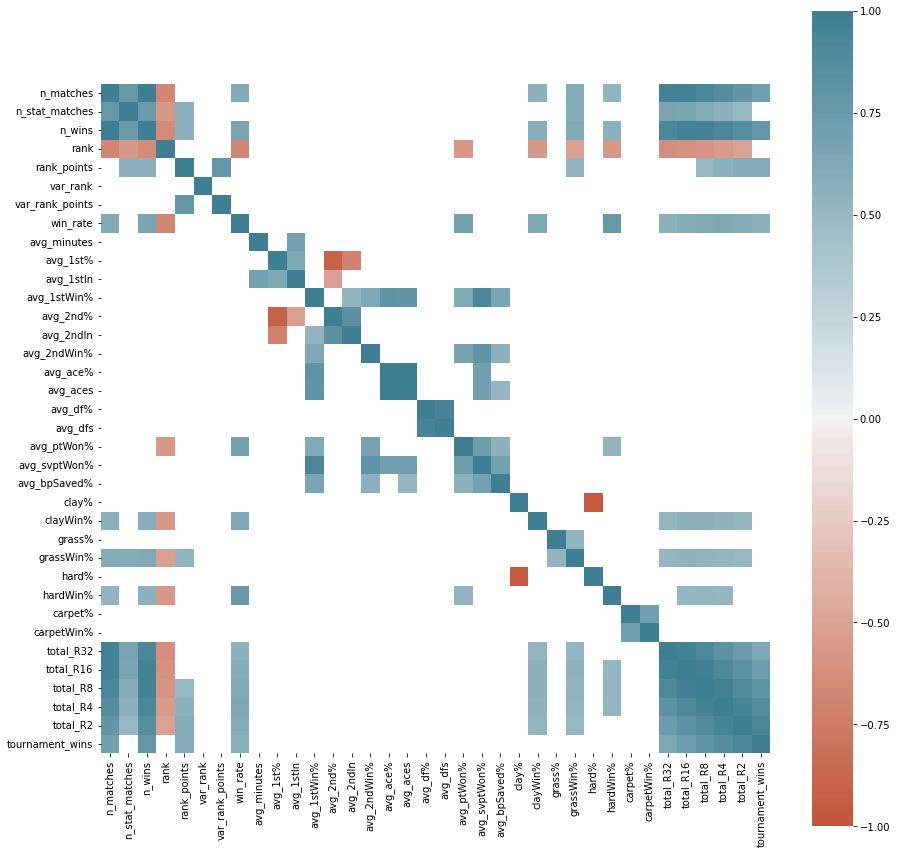

In [ ]:
# Consider all the player attributes, removing highly-correlated ones and keeping only the most descriptive ones.
# Among these that we remove for visualization, we remove the age of players, and the raw number of wins
# and games played for each surface, thus keeping only their relative percentage.

removed = ['clay','hard','carpet','grass','clayWins','grassWins','hardWins','carpetWins','age'] + Library.categorical_attributes(players_statistics)

# Exclude hidden attributes by adding the hidden tag.
for a in removed:
    players_statistics[a]['info'] += ['hidden']

# Take the correlation matrix between the most important numerical attributes on the dataset with a 0.5 threshold in absolute value.
plt.gcf().set_size_inches(15, 15)
Library.correlation_matrix(players_df[Library.numerical_attributes(players_statistics)], threshold=0.5)

<AxesSubplot:>

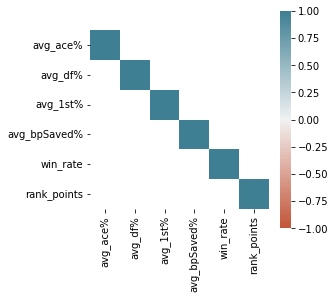

In [ ]:
# Consider the clustering attributes we searched and selected for the task.
clustering_attributes = ['avg_ace%', 'avg_df%', 'avg_1st%', 'avg_bpSaved%', 'win_rate', 'rank_points']

# Normalize the resulting data using StandardScaler.
scaler = StandardScaler()
numerical_attributes = Library.numerical_attributes(players_statistics)
norm_players_df = pd.DataFrame(scaler.fit_transform(players_df[numerical_attributes]), columns=numerical_attributes)
clustering_players_df = norm_players_df[clustering_attributes]

# As a sanity check, verify again the correlation matrix on the clustering attributes with 0.5 threshold in absolute value.
plt.gcf().set_size_inches(4, 4)
Library.correlation_matrix(clustering_players_df, threshold=0.5)

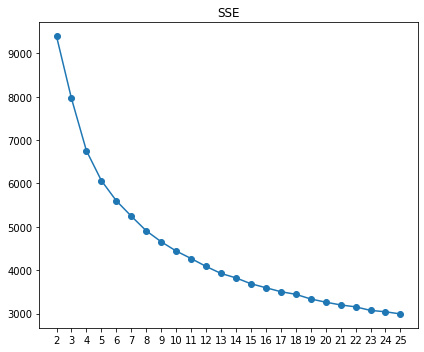

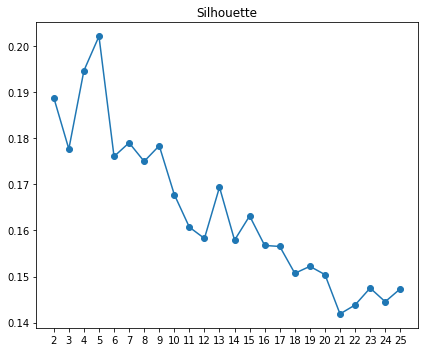

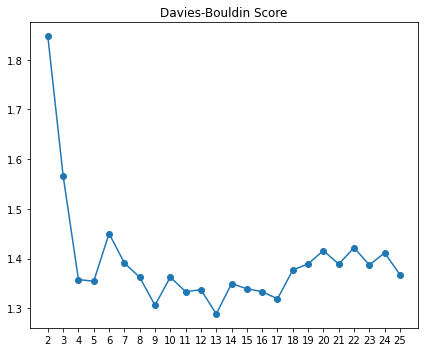

In [ ]:
# Choose the ideal number of clusters by using both SSE and Silhouette scores and using the elbow heuristic.
# The k_means algorithm is reinitialized 5 times, while still maintaining deterministic
# overall results by setting the seed and undering results reproducibility.

global_seed = 5

def plot_elbow(df, max_k, plots):
    sse, sil, dbs = [], [], []
    k_range = range(2, max_k + 1)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, n_init=5, random_state=global_seed).fit(df)
        # Add the main scores to the list.
        sse.append(kmeans.inertia_)
        sil.append(silhouette_score(df, kmeans.labels_))
        dbs.append(davies_bouldin_score(df, kmeans.labels_))

    plt.title('SSE')
    plt.gcf().set_size_inches(6, 5)
    plt.plot(list(map(str, list(k_range))), sse, marker='o')
    Library.save('kmeans_SSE.svg')
    plt.show()
    
    plt.title('Silhouette')
    plt.gcf().set_size_inches(6, 5)
    plt.plot(list(map(str, list(k_range))), sil, marker='o')
    Library.save('kmeans_Silhouette.svg')
    plt.show()
    
    plt.title('Davies-Bouldin Score')
    plt.gcf().set_size_inches(6, 5)
    plt.plot(list(map(str, list(k_range))), dbs, marker='o')
    Library.save('kmeans_Davies.svg')
    plt.show()
    
    return sse, sil, dbs

# Plot the elbow values with varying values of k.
plot_elbow(clustering_players_df, max_k=25, plots=True)
None


In [ ]:
# Select the ideal number of clusters by inspecting the elbow.
kmeans_clusters = 5
kmeans = KMeans(n_clusters=kmeans_clusters, n_init=2, random_state=2).fit(clustering_players_df)

# Print the final results and scores as a final check.
print(kmeans.inertia_, silhouette_score(clustering_players_df, kmeans.labels_), davies_bouldin_score(clustering_players_df, kmeans.labels_))

6068.970034676762 0.20329347310994103 1.3544102500148352


## <hr><center>Apply K-Means labels to the players profile</center><hr>

0    705
1    520
2    340
3    273
4     80
Name: kMeansLabels, dtype: int64


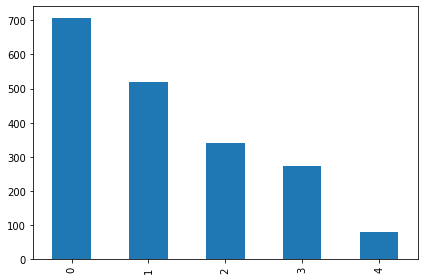

In [ ]:
# Insert the label in the original dataset to verify the statistics of each cluster.
players_df['kMeansLabels'] = kmeans.labels_

# Reorder the cluster in terms of the number of players in each cluster.
Library.reorder_clusters(players_df, 'kMeansLabels')
plt.gcf().set_size_inches(6, 4)

# See the cluster sizes and save the plots.
players_df['kMeansLabels'].value_counts().sort_index().plot(kind='bar')
Library.save('kmeans_cluster_sizes.svg')
print(players_df['kMeansLabels'].value_counts())

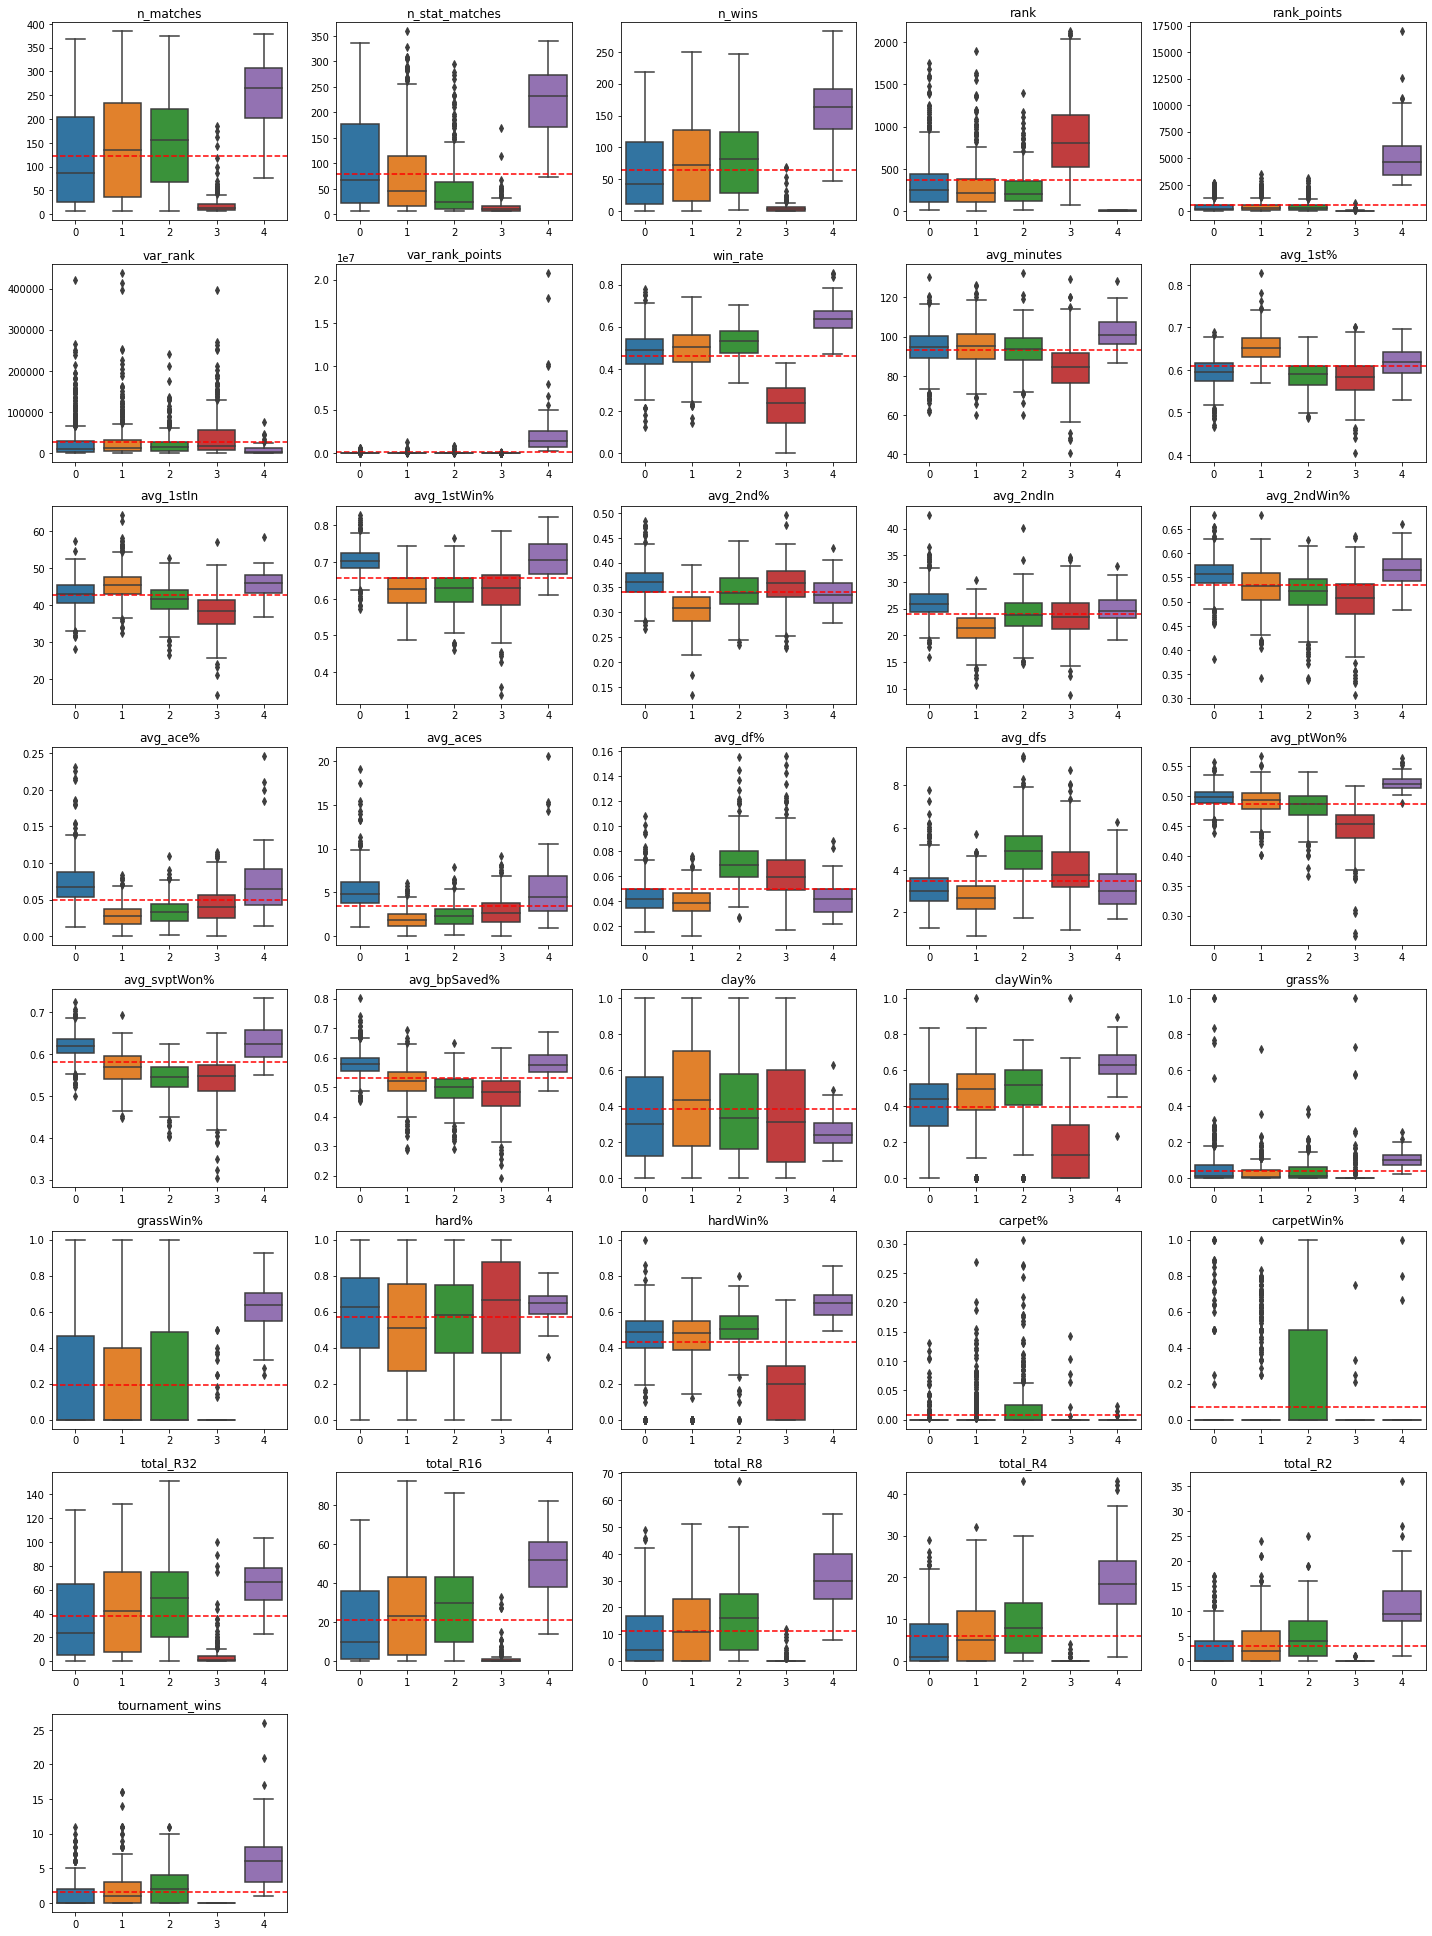

In [ ]:
# Use the Library.plot_clusters function to visualize the clusters statistics.
 
plt.gcf().set_size_inches(20, 27)
plt.gcf().tight_layout()

plt.subplots_adjust(hspace=0.35)
Library.plot_clusters(players_statistics, players_df, 'kMeansLabels')
Library.save('kmeans_boxplots.svg')

In [ ]:
# Verify that cluster 4 of Professional players actually contains the best players in the dataset.

for i in range(kmeans_clusters):
    print(i, list(players_df[(players_df['kMeansLabels'] == i) & (players_df['rank_points'] > np.percentile(players_df['rank_points'], 98))]['full_name']))

0 []
1 []
2 []
3 []
4 ['Kei Nishikori', 'Daniil Medvedev', 'Milos Raonic', 'Grigor Dimitrov', 'Andy Murray', 'Petra Kvitova', 'Karolina Pliskova', 'Johanna Konta', 'Kiki Bertens', 'Naomi Osaka', 'Novak Djokovic', 'Stanislas Wawrinka', 'Andrey Rublev', 'Kevin Anderson', 'Matteo Berrettini', 'Stefanos Tsitsipas', 'Garbine Muguruza', 'Sloane Stephens', 'Ashleigh Barty', 'Angelique Kerber', 'Rafael Nadal', 'Marin Cilic', 'Roger Federer', 'Alexander Zverev', 'Dominic Thiem', 'Simona Halep', 'Sofia Kenin', 'Venus Williams', 'Serena Williams', 'Bianca Andreescu', 'Elina Svitolina', 'Belinda Bencic', 'Aryna Sabalenka', 'Caroline Wozniacki', 'Caroline Garcia', 'Juan Martin Del Potro', 'Jelena Ostapenko', 'Dominika Cibulkova', 'Agnieszka Radwanska']


<Figure size 1440x1800 with 0 Axes>

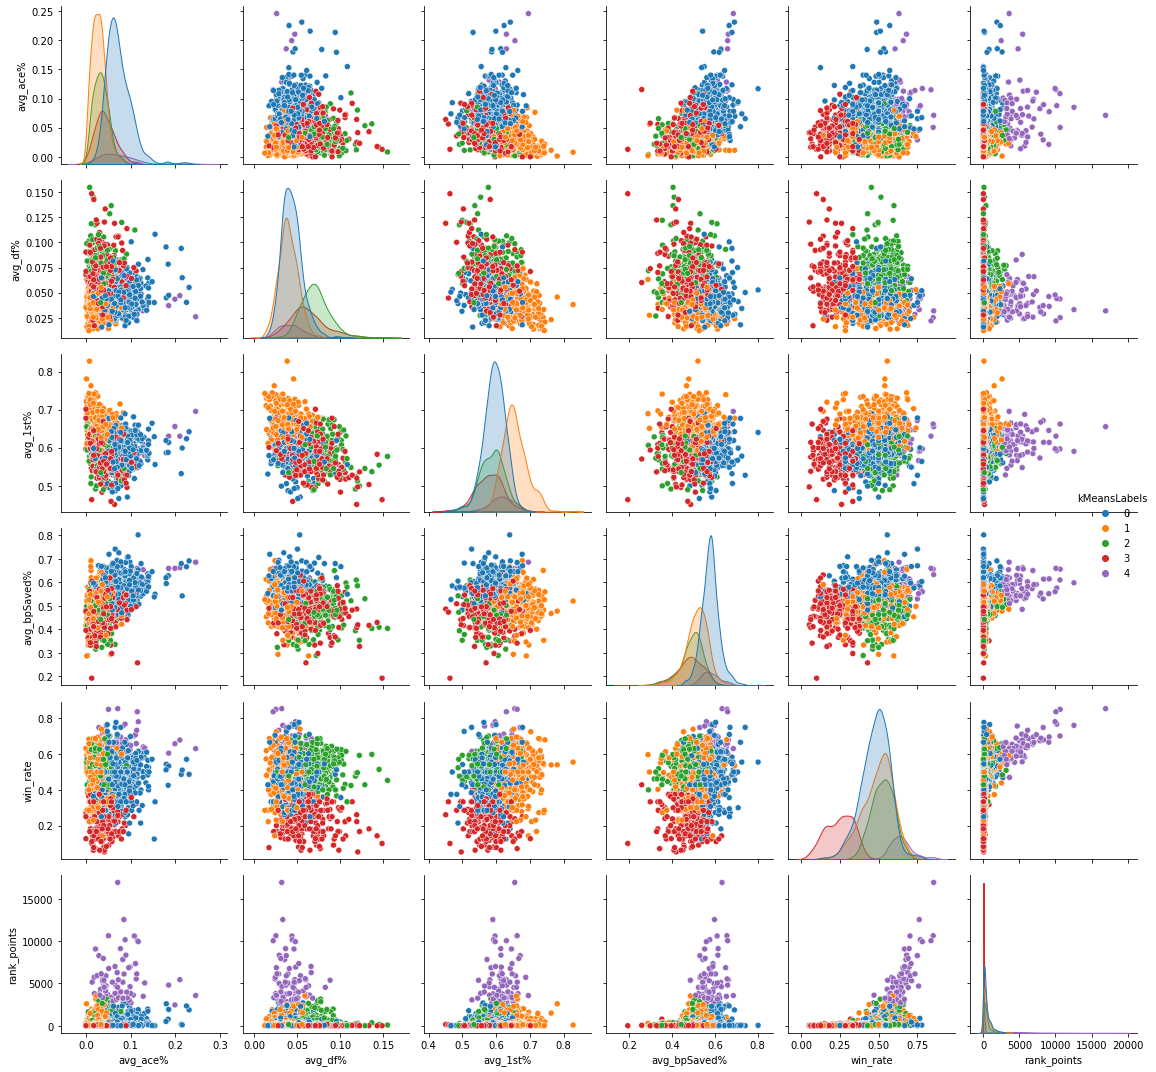

In [ ]:
# Visualize the clustering results as a scatter plot to visually inspect the partitioning.

plt.gcf().set_size_inches(20, 25)
sb.pairplot(palette=sb.color_palette(plt.rcParams['axes.prop_cycle'].by_key()['color'][:5]), hue='kMeansLabels', data=players_df[players_df['win_rate'] > 0][clustering_attributes + ['kMeansLabels']])
Library.save('kmeans_scatter.png')
plt.show()

In [ ]:
# Additionally, we check the intra-cluster distance for each cluster and their average distance.

from scipy.spatial.distance import pdist
for k in np.unique(kmeans.labels_):
    avg_dist = np.mean(pdist(
        clustering_players_df[players_df['kMeansLabels'] == k].values, 
        'euclid'))
    print(f"Average intra-cluster distance of cluster {k} = {avg_dist}")

avg_inter_dist = np.mean(pdist(kmeans.cluster_centers_, 'euclid'))
print(f"Average inter-cluster distance = {avg_inter_dist}")

Average intra-cluster distance of cluster 0 = 2.156816604186583
Average intra-cluster distance of cluster 1 = 2.0989482009776435
Average intra-cluster distance of cluster 2 = 2.221778432290382
Average intra-cluster distance of cluster 3 = 2.8021061366714197
Average intra-cluster distance of cluster 4 = 3.530309448985352
Average inter-cluster distance = 3.4121517166034345


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=52344550-8347-4668-936e-f505b5adca8e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>